In [40]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from scipy.spatial import cKDTree
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from scipy.stats import zscore
from statsmodels import robust
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from logger import ExperimentLogger
from sklearn.neural_network import MLPRegressor

# Sklearn MLP

## Load data

In [41]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_ahn_elevation.csv")
df = pd.read_csv(path)
len(df)

7620

In [42]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'elevation', 'lon', 'lat', 'precipitation', 'temperature',
       'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1',
       'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1',
       'cnratio_1', 'peattype_1', 'calciccontent_1', 'fedith_1',
       'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1',
       'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1',
       'siltcontent_1', 'groundwater_depth'],
      dtype='object')

In [43]:
# df = df[~df["soil region"].isin(["loss", "veen", "clay"])]
# len(df)

## Sort by date

In [44]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
len(df)

7620

## Feature engineering

In [45]:
# df['month_sin'] = np.sin(2*np.pi*df['date'].dt.month/12)
# df['month_cos'] = np.cos(2*np.pi*df['date'].dt.month/12)

In [46]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'elevation', 'lon', 'lat', 'precipitation', 'temperature',
       'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1',
       'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1',
       'cnratio_1', 'peattype_1', 'calciccontent_1', 'fedith_1',
       'loamcontent_1', 'minimumloamcontent_1', 'maximumloamcontent_1',
       'sandmedian_1', 'minimumsandmedian_1', 'maximumsandmedian_1',
       'siltcontent_1', 'groundwater_depth'],
      dtype='object')

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [47]:
df = df.drop(columns=['soil region', 'peattype_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'minimumsandmedian_1', 'siltcontent_1'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

5341

## Add month and year as a feature

In [48]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [49]:
# def add_neighbor_mean(df, value_col='nitrate', n_neighbors=2):
#     # Make a copy to avoid modifying the original
#     df = df.copy()
#     df['neighbor_mean'] = np.nan
    
#     # Group by year and month
#     for (year, month), group in df.groupby(['year', 'month']):
#         # Use only wells with valid lat/lon and value
#         mask = group[['lon', 'lat', value_col]].notnull().all(axis=1)
#         wells = group[mask]
#         if len(wells) < n_neighbors + 1:
#             continue  # Not enough data
        
#         coords = wells[['lon', 'lat']].values
#         tree = cKDTree(coords)
        
#         # For each well in this (year, month), find nearest neighbors
#         for idx, row in wells.iterrows():
#             # Query for n_neighbors+1 because the first neighbor is itself
#             dists, indices = tree.query([row['lon'], row['lat']], k=n_neighbors+1)
#             # Exclude itself (distance==0)
#             neighbor_indices = indices[1:n_neighbors+1]
#             neighbor_vals = wells.iloc[neighbor_indices][value_col].values
#             mean_val = np.mean(neighbor_vals)
#             df.at[idx, 'neighbor_mean'] = mean_val
    
#     return df

# df = add_neighbor_mean(df, value_col='nitrate', n_neighbors=2)

In [50]:
df = df.dropna()
len(df)

5341

## Change column type

In [51]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

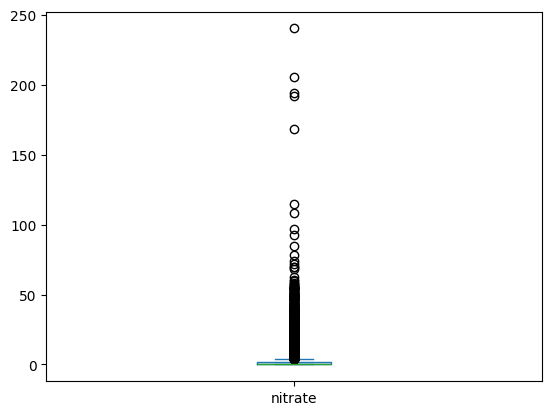

In [52]:
df[["nitrate"]].plot(kind = "box")

<Axes: >

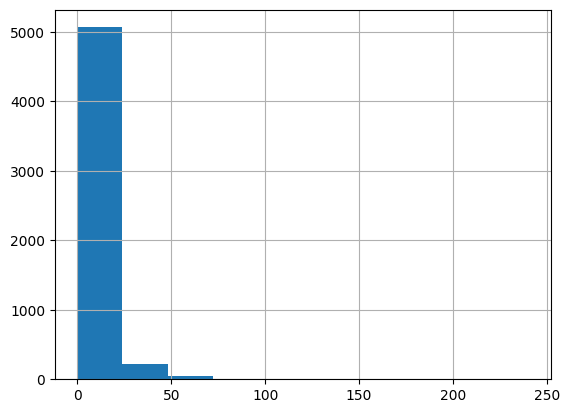

In [53]:
df["nitrate"].hist()

In [54]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-50:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

5291

## Test / train split

In [55]:
# Define the split by year
train_years = list(range(2008, 2022))
val_years = [2020, 2021]
test_years = [2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
val_df = df[df["year"].isin(val_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 4870
Val: 660
Test: 421


## Outliers

Select method that works the best

In [56]:
def get_outlier_mask(s, method='iqr', factor=1.5, z_thresh=3, mad_thresh=3.5, 
                     lower_pct=0.01, upper_pct=0.99, contamination=0.01, X=None, 
                     dbscan_eps=0.5, dbscan_min_samples=5, domain_range=None):

    if method == 'iqr':
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - factor * iqr, q3 + factor * iqr
        return (s >= lower) & (s <= upper)

    elif method == 'zscore':
        z = zscore(s, nan_policy='omit')
        return np.abs(z) < z_thresh

    elif method == 'mad':
        median = np.median(s)
        mad = robust.mad(s)
        z = 0.6745 * (s - median) / mad if mad else np.zeros_like(s)
        return np.abs(z) < mad_thresh

    elif method == 'percentile':
        lower, upper = s.quantile([lower_pct, upper_pct])
        return (s >= lower) & (s <= upper)

    elif method == 'isoforest':
        if X is None: raise ValueError("X (DataFrame) required for Isolation Forest.")
        iso = IsolationForest(contamination=contamination, random_state=42)
        outlier_pred = iso.fit_predict(X)
        return outlier_pred == 1

    elif method == 'lof':
        if X is None: raise ValueError("X (DataFrame) required for LOF.")
        lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
        outlier_pred = lof.fit_predict(X)
        return outlier_pred == 1

    elif method == 'dbscan':
        if X is None: raise ValueError("X (DataFrame) required for DBSCAN.")
        db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(X)
        return db.labels_ != -1

    elif method == 'domain':
        if domain_range is None: raise ValueError("Specify domain_range=(min, max) for 'domain' method.")
        lower, upper = domain_range
        return (s >= lower) & (s <= upper)

    else:
        raise ValueError(f"Unknown outlier removal method: {method}")


outlier_method = "iqr"
lower, upper = 0, 100
domain_range=(lower, upper)

mask_train = get_outlier_mask(train_df['nitrate'], method=outlier_method, X=train_df)
lb, ub = train_df.loc[mask_train, 'nitrate'].min(), train_df.loc[mask_train, 'nitrate'].max()

train_df = train_df[mask_train]
val_df   = val_df[(val_df['nitrate'] >= lb) & (val_df['nitrate'] <= ub)]
test_df  = test_df[(test_df['nitrate'] >= lb) & (test_df['nitrate'] <= ub)]

print(f"Train rows after outlier filter: {len(train_df):,}")
print(f"Val   rows after outlier filter: {len(val_df):,}")
print(f"Test  rows after outlier filter: {len(test_df):,}")


Train rows after outlier filter: 3,866
Val   rows after outlier filter: 550
Test  rows after outlier filter: 355


In [57]:
# def iqr_bounds(s, factor: float = 1.5):
#     """Return (lower, upper) IQR bounds for a Series."""
#     q1, q3 = s.quantile([0.25, 0.75])
#     iqr = q3 - q1
#     return q1 - factor * iqr, q3 + factor * iqr

# lb, ub = iqr_bounds(train_df['nitrate'])      # ← only training stats
# train_df = train_df[(train_df['nitrate'] >= lb) & (train_df['nitrate'] <=  ub)]
# test_df  = test_df [(test_df ['nitrate'] >= lb) & (test_df ['nitrate'] <=  ub)]

# print(f"Train rows after outlier filter: {len(train_df):,}")
# print(f"Test  rows after outlier filter: {len(test_df):,}")

In [58]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_val = val_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_val = val_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [59]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [60]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'maximumloamcontent_1', 'sandmedian_1', 'maximumsandmedian_1', 'groundwater_depth']
All X_train columns: ['landuse code', 'population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'maximumloamcontent_1', 'sandmedian_1', 'maximumsandmedian_1', 'groundwater_depth']


In [61]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [62]:
mlp_model = MLPRegressor(
    random_state=123,
    max_iter=1000,
    early_stopping=True
)
pipe = Pipeline([
    ("prep", preprocessor),
    ("mlp", mlp_model)
])

In [63]:
full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [64]:
param_grid = {
    'regressor__mlp__hidden_layer_sizes': [(6,), (8,), (10,)],
    'regressor__mlp__alpha': [0.001, 0.01, 0.05, 0.1],
    'regressor__mlp__learning_rate_init': [0.001, 0.01, 0.05, 0.1],
    'regressor__mlp__activation': ['relu', 'tanh'],
}

## Hyperparameter tuning

In [65]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_grid,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    random_state=123,
    verbose=1
)
search.fit(X_train, y_train)
mlp_model = search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [66]:
print(search.best_estimator_.get_params())

{'check_inverse': True, 'func': <ufunc 'log1p'>, 'inverse_func': <ufunc 'expm1'>, 'regressor__memory': None, 'regressor__steps': [('prep', ColumnTransformer(transformers=[('cat_ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['landuse code', 'mainsoilclassification_1']),
                                ('num_scaler', StandardScaler(),
                                 ['population', 'elevation', 'precipitation',
                                  'temperature', 'n deposition',
                                  'organicmattercontent_1', 'density_1',
                                  'acidity_1', 'minimumacidity_1',
                                  'maximumacidity_1', 'cnratio_1',
                                  'maximumloamcontent_1', 'sandmedian_1',
                                  'maximumsandmedian_1',
                                  'groundwater_dep

In [67]:
fitted_mlp = mlp_model.regressor_.named_steps['mlp']

## Learning curve

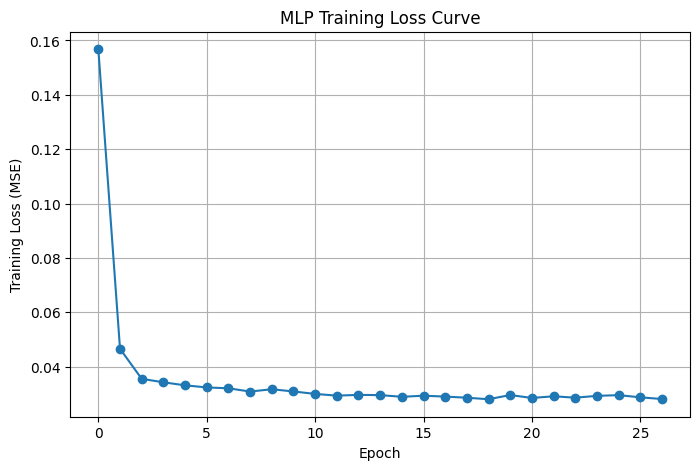

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(fitted_mlp.loss_curve_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('MLP Training Loss Curve')
plt.grid(True)
plt.show()

In [69]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.2102355697959976
Best params: {'regressor__mlp__learning_rate_init': 0.05, 'regressor__mlp__hidden_layer_sizes': (6,), 'regressor__mlp__alpha': 0.05, 'regressor__mlp__activation': 'relu'}


## Final Train score

In [70]:
pred_train = mlp_model.predict(X_train)

In [71]:
pred_train = mlp_model.predict(X_train)

train_r2 = r2_score(y_train, pred_train)
train_mae = mean_absolute_error(y_train, pred_train)
train_rmse = sqrt(mean_squared_error(y_train, pred_train))

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.34264394894875294
Train MAE: 0.20907386693316649
Test RMSE: 0.4607556352702043


## Final Test score

In [72]:
pred_nitrate = mlp_model.predict(X_test)

test_r2 = r2_score(y_test, pred_nitrate)
test_mae = mean_absolute_error(y_test, pred_nitrate)
test_rmse = sqrt(mean_squared_error(y_test, pred_nitrate))

print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

Test R2: 0.22271652229118444
Test MAE: 0.24520701621640534
Test RMSE: 0.5225342129671006


In [73]:
pred_nitrate

array([ 6.59602782e-02, -5.92825006e-02,  2.69462025e-01,  3.90081305e-02,
        2.69185560e-01,  2.70669712e-02,  4.52386909e-01,  4.78819931e-02,
       -6.19786612e-02,  7.81181213e-02,  3.31068952e-02,  4.31617019e-02,
       -1.51033412e-02,  2.04831884e-01,  2.81111717e-02,  2.16802422e-02,
        8.40706337e-02, -8.23640098e-03,  8.59052784e-02,  1.21138934e-01,
        9.90649832e-02,  5.03235169e-02,  4.58372993e-02,  1.19742020e-02,
        2.46601193e-01, -2.85834340e-02,  2.88360059e-01,  2.88360059e-01,
        4.65833285e-02, -2.77108297e-02,  2.10084032e-01,  5.94303778e-02,
        1.86950527e-01,  3.67745693e-01, -9.27966622e-03,  8.46832821e-02,
        2.38651230e-01,  1.92964394e-01,  6.12158641e-02,  4.09448485e-02,
        2.66677892e-02,  1.34001812e-01,  1.29870010e-01,  8.48072722e-02,
        9.54382523e-02, -1.86667919e-02, -1.86667919e-02, -4.31709099e-02,
        5.14470445e-02, -3.11203057e-02,  1.03102688e-01,  7.51679355e-03,
        2.45886012e-01,  

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

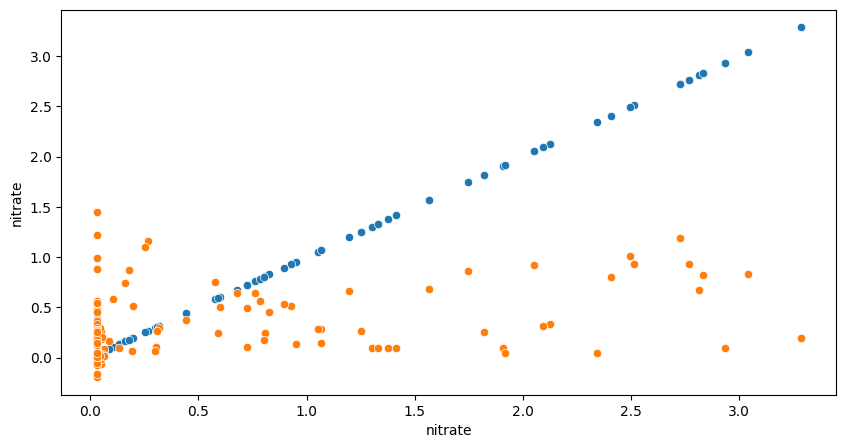

In [74]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

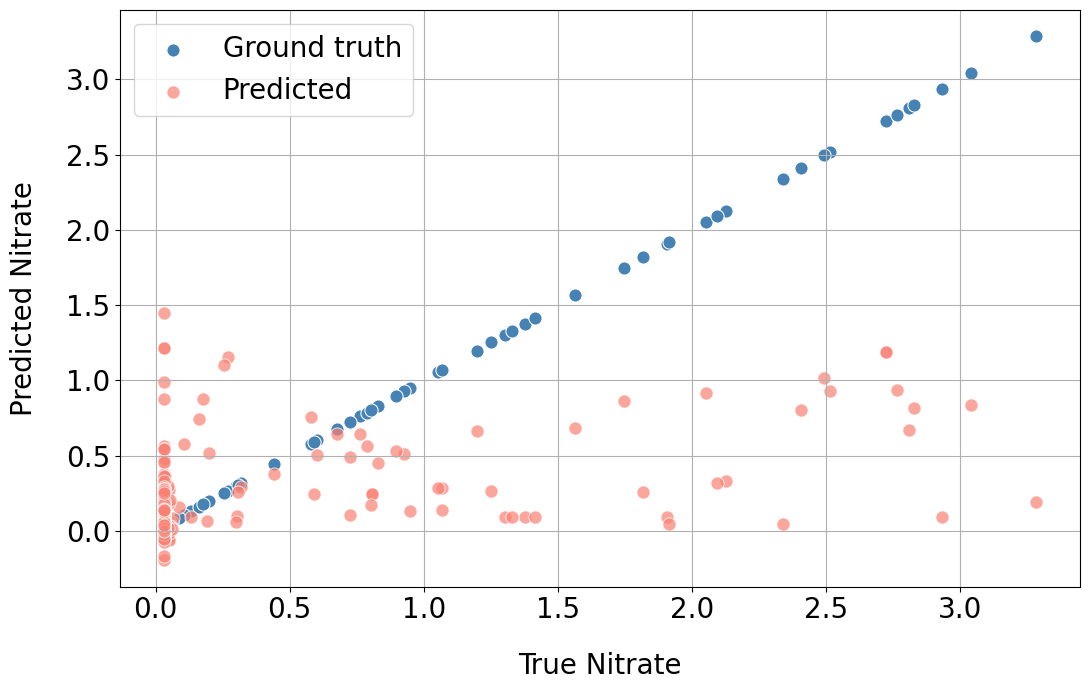

In [75]:
fig, ax = plt.subplots(figsize=(11, 7))

# Ground truth (diagonal reference line)
sns.scatterplot(x=y_test, y=y_test, ax=ax, label="Ground truth", s=90, color="steelblue")

# Model predictions
sns.scatterplot(x=y_test, y=pred_nitrate, ax=ax, label="Predicted", s=90, color="salmon", alpha=0.7)

# Labels and style
ax.set_xlabel("True Nitrate", fontsize=20, labelpad=20)
ax.set_ylabel("Predicted Nitrate", fontsize=20, labelpad=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()

## Residuals

In [76]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.ylim(top=12)

NameError: name 'best_model' is not defined

In [1349]:
residuals.to_csv("rf_residuals.csv")

## Predictions on the map

In [1350]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

876
876
876
876


In [1351]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

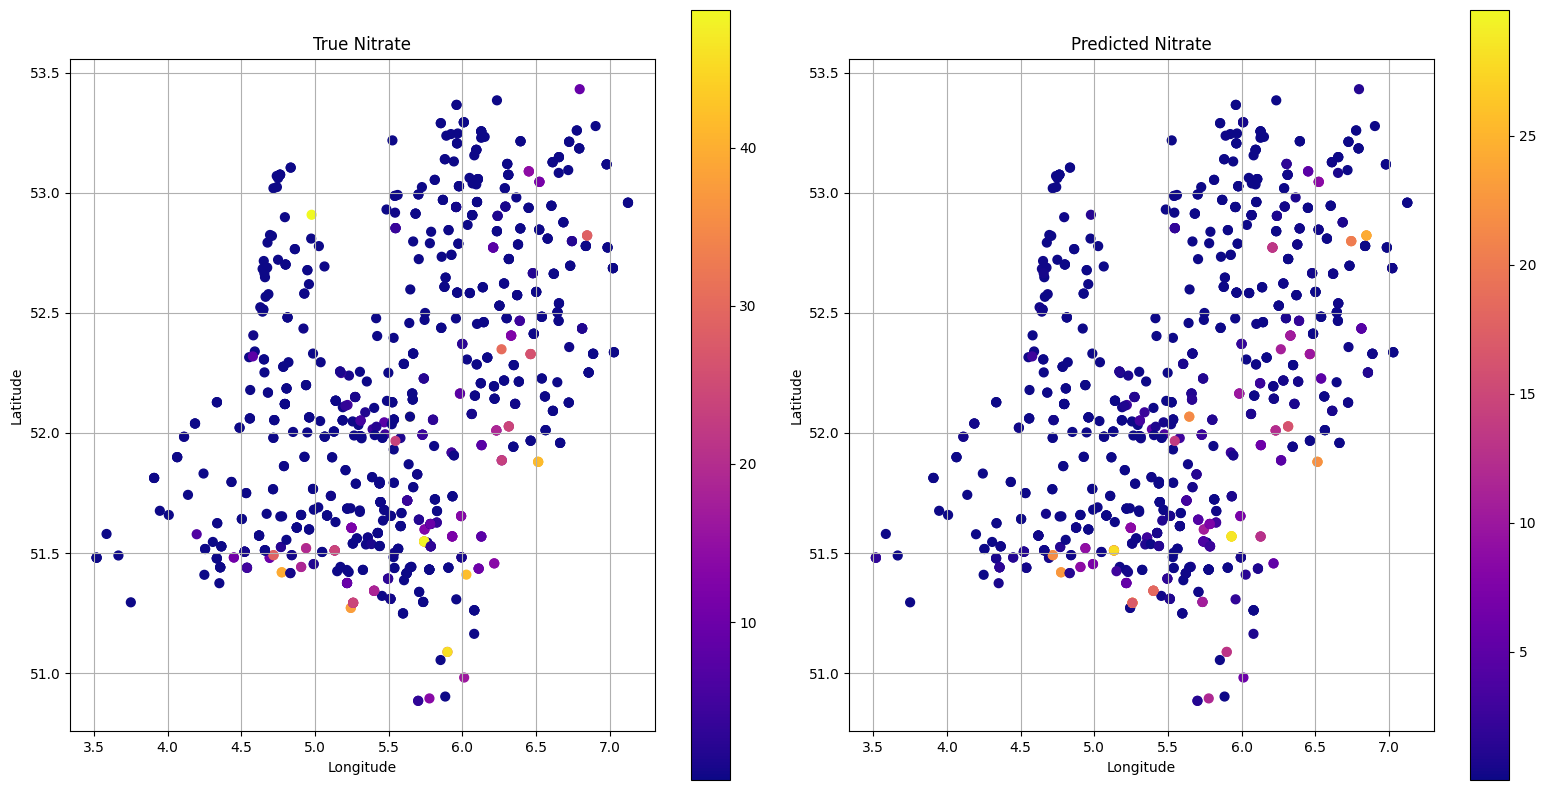

In [1352]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

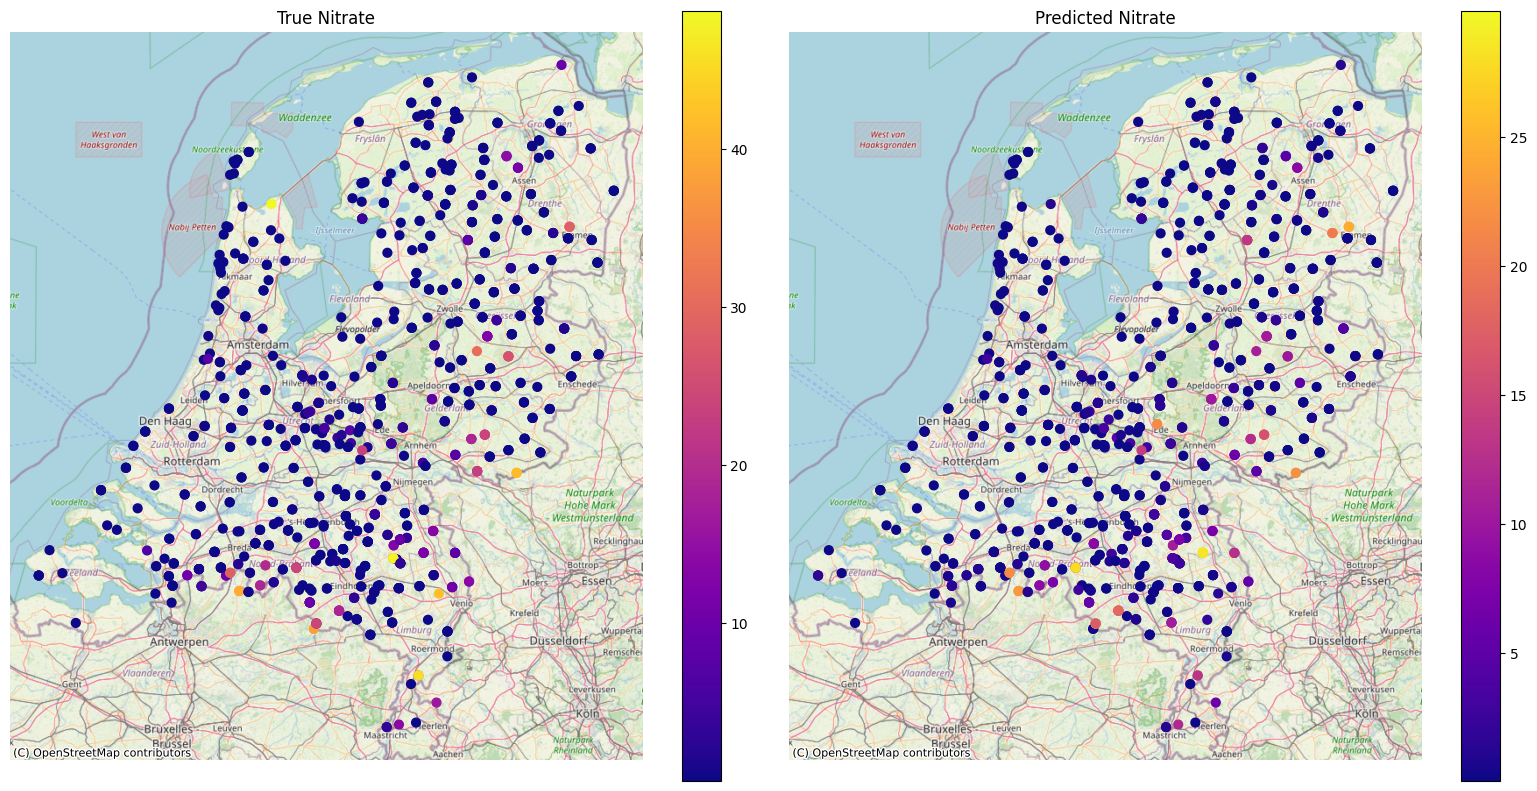

In [1353]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

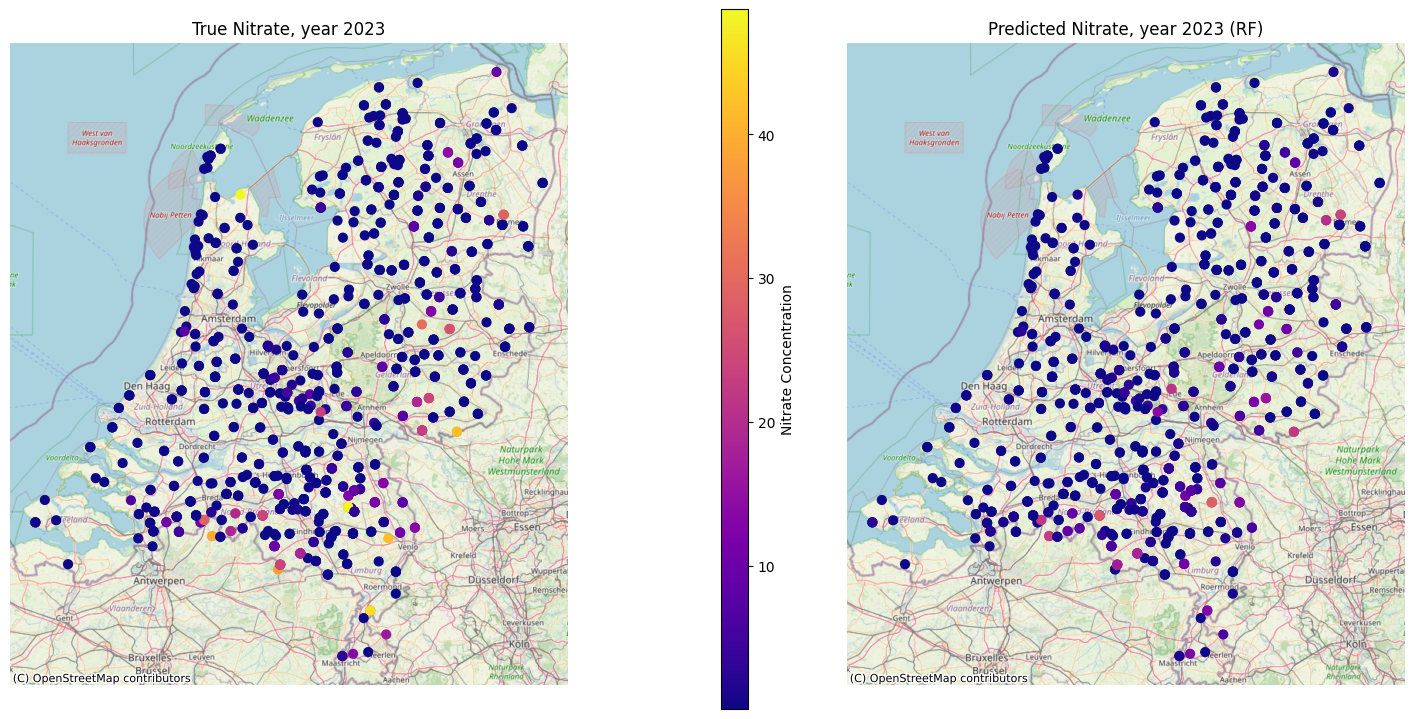

In [1354]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

gdf_3857 = gdf.to_crs(epsg=3857)

vmin = min(gdf_3857["nitrate_true"].min(), gdf_3857["nitrate_pred"].min())
vmax = max(gdf_3857["nitrate_true"].max(), gdf_3857["nitrate_pred"].max())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma
sm = ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

fig, axs = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={"wspace": 0.5})

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (RF)")

for ax in axs:
    ax.set_axis_off()

cbar_ax = fig.add_axes([0.52, 0.15, 0.015, 0.7])
fig.colorbar(sm, cax=cbar_ax, label="Nitrate Concentration")

plt.show()


## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

In [1355]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1',
                                                                                        'minimumacidity_1',
                                                                                        'maximumacidity_1',
                                                                                        'cnratio_1',
                                                                                        'maximumloamcontent_1',
                                                                                        'sandmedian_1',
                                                                                        'maximumsandmedian_1',
                                                                                        'groundwater_depth'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            min_samples_split=4,
                                                                            random_state=123))]))

In [1356]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [1357]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['rf']

feature_names = fitted_preprocessor.get_feature_names_out()

importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature    importance
54                              num_scaler__elevation  2.571888e-01
41  cat_ohe__mainsoilclassification_1_Dikke eerdgr...  1.300941e-01
67                      num_scaler__groundwater_depth  1.069929e-01
57                           num_scaler__n deposition  7.410755e-02
59                              num_scaler__density_1  6.012771e-02
..                                                ...           ...
28                         cat_ohe__landuse code_39.0  9.577923e-07
32                         cat_ohe__landuse code_43.0  5.295432e-07
29                         cat_ohe__landuse code_40.0  1.617742e-07
52  cat_ohe__mainsoilclassification_1_Zeer oude ma...  1.169505e-07
23                         cat_ohe__landuse code_34.0  0.000000e+00

[68 rows x 2 columns]


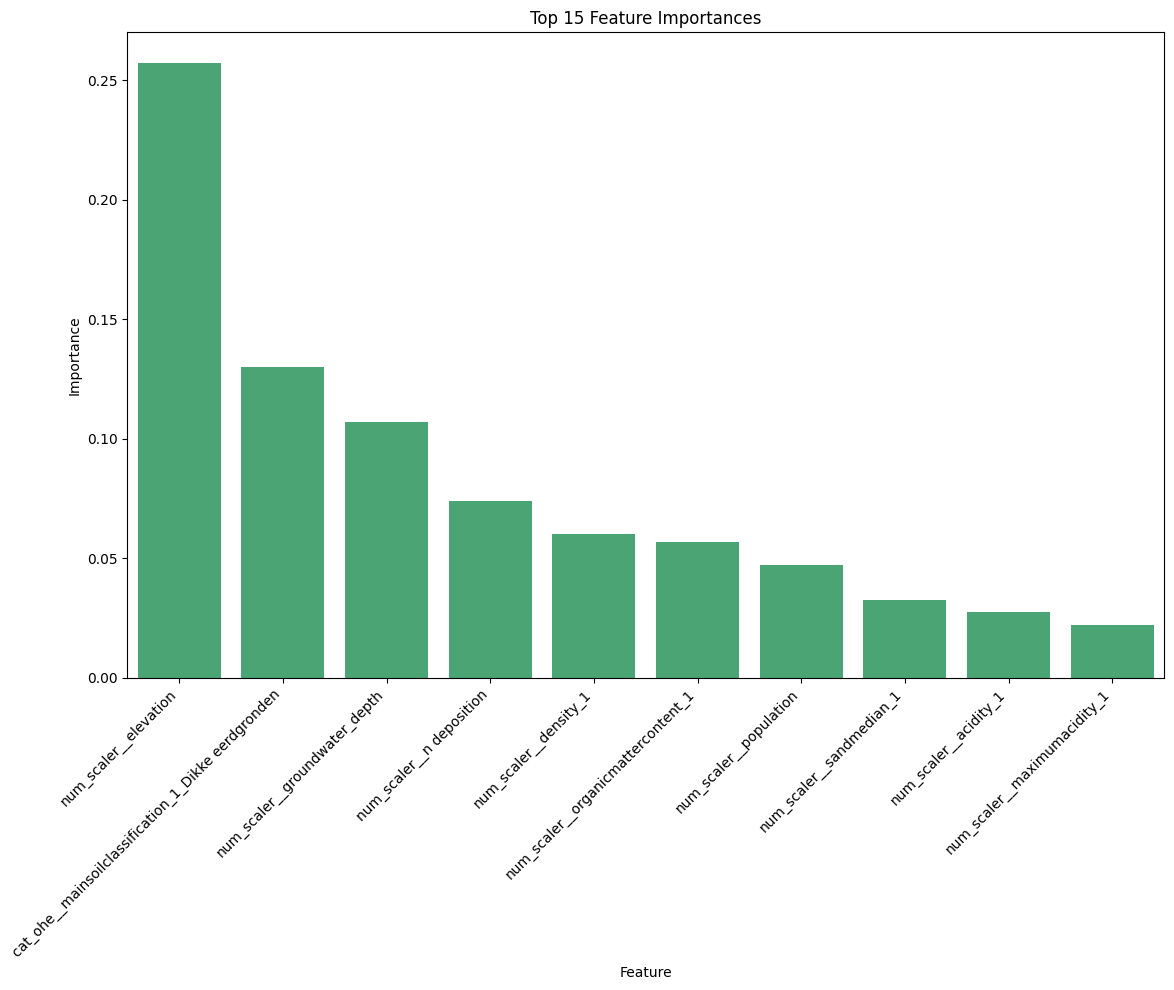

In [1358]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(10), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [1359]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month

# Model-Agnostic

In [1360]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

  0%|          | 0/50 [00:00<?, ?it/s]

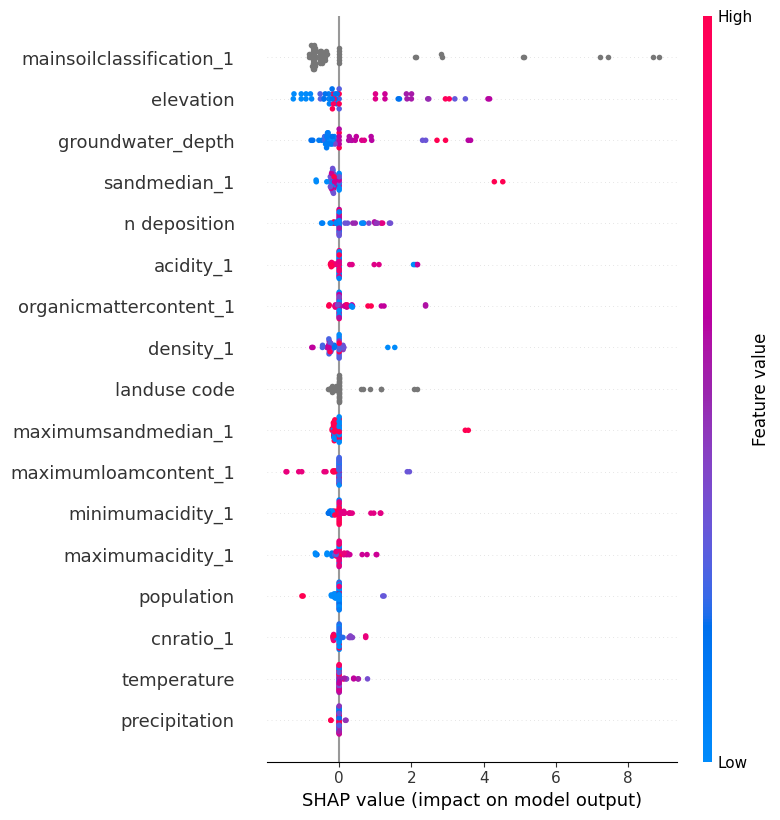

In [1361]:
# Use minimal SHAP setup (no deep or tree models)
from shap.explainers import Kernel
import lime.lime_tabular
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Safe SHAP wrapper
def shap_predict(X_array):
    X_df = pd.DataFrame(X_array, columns=X_test.columns)
    return best_model.predict(X_df)

# Background data
X_background = X_train.sample(100, random_state=0)
explainer_shap = Kernel(shap_predict, X_background)
shap_values = explainer_shap.shap_values(X_test.iloc[:50])

# SHAP plot
import shap
shap.summary_plot(shap_values, X_test.iloc[:50])

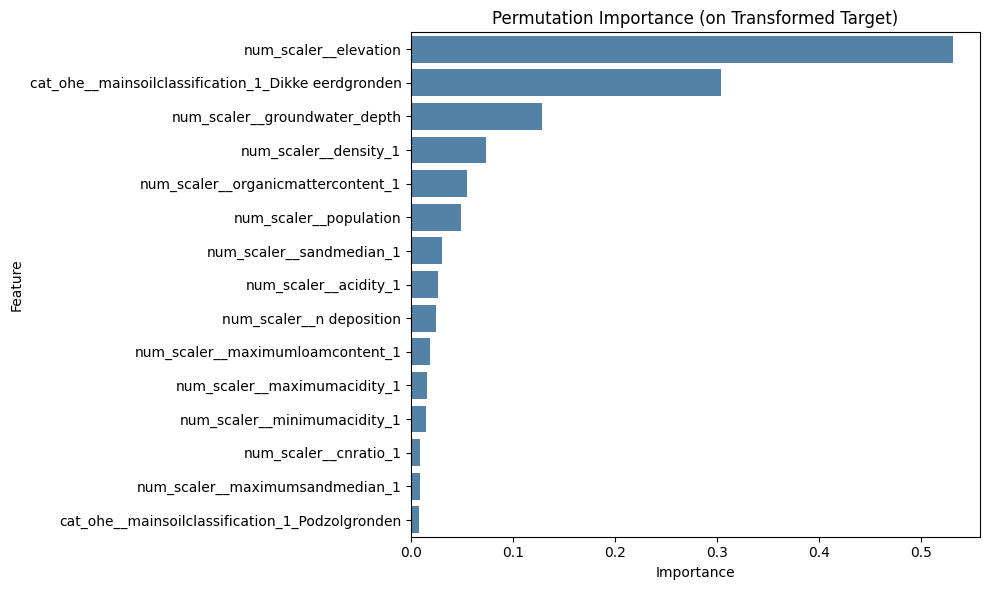

In [1362]:
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"


In [1363]:
curr_dir = os.getcwd()
log_path = os.path.join(curr_dir, '../../logging/experiment_log.json')

# After each notebook run, do this!
logger = ExperimentLogger(save_path=log_path)

model = "Random Forest"
hyperparams = search.best_params_
outlier_method = outlier_method
train_score = {"R2": train_r2, "MAE": train_mae, "RMSE": train_rmse}
test_score = {"R2": test_r2, "MAE": test_mae, "RMSE": test_rmse}

logger.log(
    model = model,
    hyperparams=hyperparams,
    outlier_method=outlier_method,
    train_score=train_score,
    test_score=test_score,
    extra_info={"note": "Removed soil region"}
)

{'model': 'Random Forest',
 'timestamp': '2025-07-06T20:15:28.585918',
 'hyperparameters': {'regressor__rf__n_estimators': 100,
  'regressor__rf__min_samples_split': 4,
  'regressor__rf__min_samples_leaf': 1,
  'regressor__rf__max_features': 0.5,
  'regressor__rf__max_depth': 15},
 'outlier_method': 'iqr',
 'train_score': {'R2': 0.8853978221879775,
  'MAE': 0.7986504598089696,
  'RMSE': 2.6503941551007295},
 'test_score': {'R2': 0.503154035488847,
  'MAE': 1.680724327575318,
  'RMSE': 5.3319508851959405},
 'note': 'Removed soil region'}